In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

df = pd.read_csv("data/allendale-students.csv")

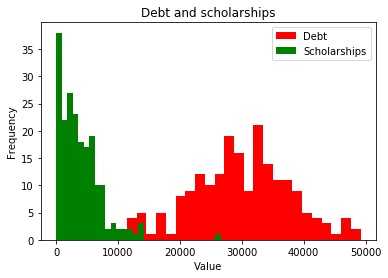

In [33]:
n_bins = 30
colors = ["red", "green"]
plt.hist(df.debt, bins=n_bins, color=colors[0])
plt.hist(df.scholarship, bins=n_bins, color=colors[1])
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title("Debt and scholarships")
labels= ["Debt","Scholarships"]
_ = plt.legend(labels)

In [34]:
df_with_dummies = pd.get_dummies(df).drop(columns=['housing_off campus', 'major_STEM']) 
df_with_dummies.columns = df_with_dummies.columns.str.replace(' ', '_')
df_with_dummies # off-campus and stem majors are reference catgories

,distance,scholarship,parents,car,debt,housing_on_campus,major_business,major_other
0,40,1532,0.440,6,26389,0,0,0
1,30,7479,0.265,7,21268,1,0,0
2,130,2664,0.115,3,32312,1,1,0
3,120,1998,0.325,9,28539,1,1,0
4,30,1462,0.105,10,34867,0,0,1
...,...,...,...,...,...,...,...,...
195,30,5321,0.445,8,21873,0,0,0
196,50,5916,0.020,10,33122,0,0,0
197,410,5583,0.200,7,33666,1,1,0
198,320,1282,0.250,4,44262,0,1,0


### Correlation matrix

In [35]:
corr_matrix = df_with_dummies.corr()
corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool)) # rm vals on upper tri
corr_matrix_uns = corr_matrix.unstack()
corr_df = pd.DataFrame(corr_matrix_uns).dropna()
corr_df.reset_index(inplace=True)
corr_df.columns = ['var1', 'var2', 'corr']
corr_df = corr_df[corr_df['corr']<1]
corr_df.sort_values(by=['corr'], ascending=False).head(10)

,var1,var2,corr
4,distance,debt,0.498096
24,car,major_business,0.131968
5,distance,housing_on_campus,0.124229
19,parents,major_business,0.108633
28,debt,major_business,0.103186
27,debt,housing_on_campus,0.098850
10,scholarship,car,0.031174
7,distance,major_other,0.021034
6,distance,major_business,0.019318
3,distance,car,0.007354


In [36]:
predictors = df_with_dummies.drop(columns='debt')
cols = predictors.columns

## Get formula

In [77]:
formula_list = []
n_columns = len(cols) + 1
for i in range(1, n_columns):
    iters = combinations(cols, i)
    for item in iters:
        formula = "debt ~ " + " + ".join(item)
        formula_list.append(formula)

In [79]:
formula_list = []
n_columns = len(cols) + 1
for i in range(1, n_columns):
    iters = combinations(cols, i)
    for item in iters:
        formula = "debt ~ " + " + ".join(item)
        formula_list.append(formula)

['debt ~ distance',
 'debt ~ scholarship',
 'debt ~ parents',
 'debt ~ car',
 'debt ~ housing_on_campus',
 'debt ~ major_business',
 'debt ~ major_other',
 'debt ~ distance + scholarship',
 'debt ~ distance + parents',
 'debt ~ distance + car',
 'debt ~ distance + housing_on_campus',
 'debt ~ distance + major_business',
 'debt ~ distance + major_other',
 'debt ~ scholarship + parents',
 'debt ~ scholarship + car',
 'debt ~ scholarship + housing_on_campus',
 'debt ~ scholarship + major_business',
 'debt ~ scholarship + major_other',
 'debt ~ parents + car',
 'debt ~ parents + housing_on_campus',
 'debt ~ parents + major_business',
 'debt ~ parents + major_other',
 'debt ~ car + housing_on_campus',
 'debt ~ car + major_business',
 'debt ~ car + major_other',
 'debt ~ housing_on_campus + major_business',
 'debt ~ housing_on_campus + major_other',
 'debt ~ major_business + major_other',
 'debt ~ distance + scholarship + parents',
 'debt ~ distance + scholarship + car',
 'debt ~ distance + 

In [38]:
def count_params(model):
    params = model.replace("+", ",")
    params = params.replace("debt ~", "")
    n_params = params.count(',') + 1
    return n_params

def get_r_sq(model):
    mod = smf.ols(formula=model, data=df_with_dummies)
    res = mod.fit()
    return res.rsquared_adj

def get_coefs(model):
    mod = smf.ols(formula=model, data=df_with_dummies)
    res = mod.fit()
    return res.params

In [76]:
adj_r_df = pd.DataFrame({'model': formula_list, 
                         'adj_rsq': map(get_r_sq, formula_list),
                         'n_params': map(count_params, formula_list),
                         'coefs': map(get_coefs, formula_list) # we really dont want to run this twice :(
})

In [42]:
coefs = pd.DataFrame(adj_r_df.coefs.tolist())
model_results = pd.concat([adj_r_df.reset_index(drop=True), coefs], axis=1)
model_results = model_results.drop(columns=['coefs'])

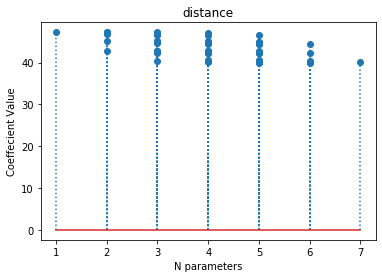

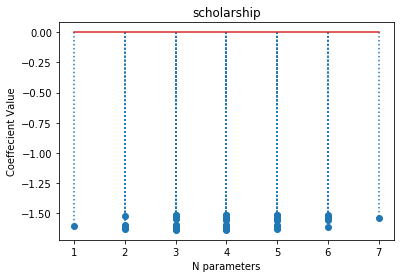

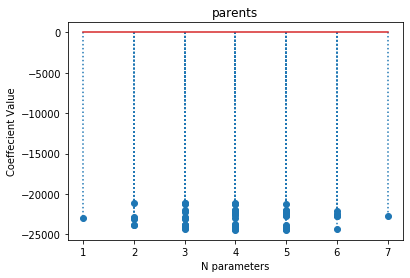

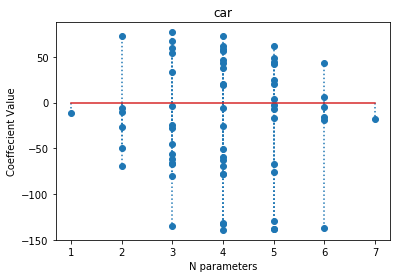

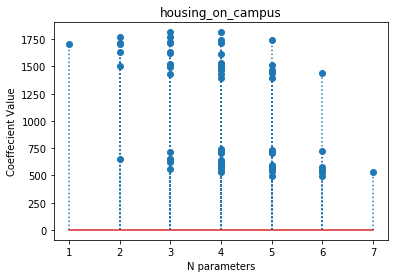

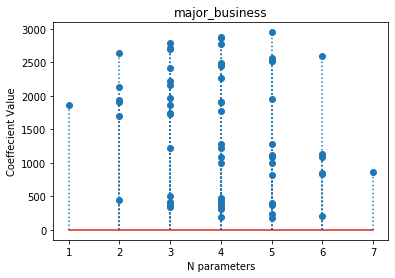

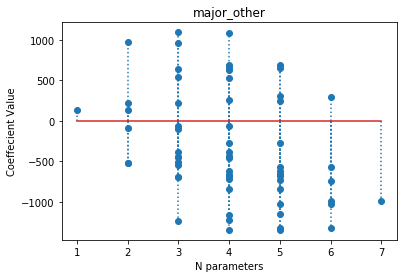

In [43]:
terms = model_results.columns[4:]
for term in terms:
    plt.stem(model_results.n_params, model_results[term], use_line_collection=True, linefmt=':')
    plt.ylabel('Coeffecient Value')
    plt.xlabel('N parameters')
    plt.title(term)
    plt.show()

In [44]:
reg_output = model_results.iloc[:,4:]

reg_output_min = reg_output.min()
reg_output_max = reg_output.max()
zeros = np.where((reg_output_min>0) | (reg_output_max<0), 1, 0)
reg = pd.DataFrame({"zero_in_range": zeros,
                    "max": reg_output_max,
                    "min": reg_output_min})
reg

,zero_in_range,max,min
distance,1,47.263715,39.993163
scholarship,1,-1.510587,-1.637079
parents,1,-21102.283253,-24444.948252
car,0,76.826684,-139.217687
housing_on_campus,1,1814.031661,493.153200
major_business,1,2951.210868,175.608545
major_other,0,1095.279959,-1344.525465


In [45]:
#TODO: do same for all two-way interactions
